<a href="https://colab.research.google.com/github/RSNA/MagiciansCorner/blob/master/ImageWrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Cell #1
# Copyright (C) Bradley J Erickson and RSNA, 2019
# The first cell (run Cell #1) loads in a few data sets of interest, including: T1, T2, GAD on several subjects with brain tumors. 
# these are DICOM images, so we have to first convert them to nifti
# and the nifti converter leaves the output in the source folder, so we have
# to move them and also rename them. Will use python for that

# The accompanying article can be found at:
# https://pubs.rsna.org/doi/full/10.1148/ryai.2019190126

!rm -rf MC-ImageWrangling


!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=12yk9kJzY-8T68cvkes_YtKsBfjwk4WYk' -O ./Bet-n-dcm2nii.zip
!unzip -q ./Bet-n-dcm2nii.zip
!rm -rf images

!mkdir images
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=19SuwH3NbFweutkFpa3W7tieF351yvDRM' -O ./S1-4.zip
!cd images; unzip -q "../S1-4.zip" 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kE8dqVUBwUuyh3ZSj5h2cPZqJMj0G6P2' -O ./S5-8.zip
!cd images; unzip -q "../S5-8.zip" 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1f5ncqzCVNugrRppzxqKuwqz1WxETszUP' -O ./S9-12.zip
!cd images; unzip -q "../S9-12.zip" 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1raVoqd6Egfy3C0Hw4m-gL0Aw3wNEzcKd' -O ./S13-16.zip
!cd images; unzip -q "../S13-16.zip" 

!rm -rf nii
!rm -rf tmp

!mkdir tmp
!mkdir nii

NIFTI_PATH = './nii'
# now some python code to loop over all the folders and convert from DICOM to nifti
# and then since the command doesn't allow speciyfing the name, will also move
#them from temp directory to an organized directory.
# this is why seemingly simple tasks always take longer than planned...

import os, fnmatch

for subj in fnmatch.filter(os.listdir('./images'), 'S*'):
    subj_path = os.path.join('./images', subj)
    series = os.listdir(subj_path)
    series = ['T1', 'T2', 'GAD']
    for ser in series:
        dcm_path = os.path.join (subj_path, ser)
        cmd = "./dcm2nii -o tmp %s" % (dcm_path)
        os.system(cmd)
#        print (cmd)
        # now have to find tehe .nii.gz and move it out
        f = fnmatch.filter(os.listdir('./tmp'), '*.nii.gz')
        out_dir = os.path.join (NIFTI_PATH, subj)
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)
        out_path = os.path.join (out_dir, ser)
        cmd = "mv ./tmp/%s %s.nii.gz" % (f[0], out_path)
        os.system(cmd)
#        print (cmd)


--2019-11-21 16:16:45--  https://docs.google.com/uc?export=download&id=12yk9kJzY-8T68cvkes_YtKsBfjwk4WYk
Resolving docs.google.com (docs.google.com)... 172.217.214.100, 172.217.214.113, 172.217.214.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pa92nd97tk3jqdk7vj0o3g0d46tb9s1q/1574352000000/16160187475894979440/*/12yk9kJzY-8T68cvkes_YtKsBfjwk4WYk?e=download [following]
--2019-11-21 16:16:46--  https://doc-0o-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pa92nd97tk3jqdk7vj0o3g0d46tb9s1q/1574352000000/16160187475894979440/*/12yk9kJzY-8T68cvkes_YtKsBfjwk4WYk?e=download
Resolving doc-0o-60-docs.googleusercontent.com (doc-0o-60-docs.googleusercontent.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to doc-0o-60-docs.googleusercontent.com (doc-0o

In [0]:
# CELL #2
# Now do some basic processing to prepare the images
# Note this will take about 30 minutes to complete.
# If you want to skip it, the output is already computed and saved for next cell


# FSL (flirt-the image registration application) complains if this environment variable is not set
os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'

for subj in os.listdir(NIFTI_PATH):
    subj_path = os.path.join(NIFTI_PATH, subj)
    print ("Working on " + subj_path)
    series = fnmatch.filter(os.listdir(subj_path), '*.nii.gz')
    for ser in ['T1', 'T2', 'GAD']:
        nii_file = os.path.join (subj_path, ser)
# First, perform N4 bias correction. Not required, but may improve results. Also must track new names
        new_file = os.path.join (subj_path, 'N4-' + ser)
        cmd = "./N4BiasFieldCorrection -i %s.nii.gz -o %s.nii.gz" % (nii_file, new_file)
        os.system(cmd)
#        print (cmd)
# Next, Register the images to the post-Gad images so skip the GAD
    GAD_file = os.path.join (subj_path, 'N4-GAD.nii.gz')
    T1_file =  os.path.join (subj_path, 'N4-T1.nii.gz')
    new_file = os.path.join (subj_path, 'Reg-T1.nii.gz')
    cmd = "./flirt -in %s -ref %s  -out %s" % (T1_file, GAD_file, new_file)
    os.system(cmd)
#    print (cmd)
    T2_file =  os.path.join (subj_path, 'N4-T2.nii.gz')
    new_file = os.path.join (subj_path, 'Reg-T2.nii.gz')
    cmd = "./flirt -in %s -ref %s  -out %s" % (T2_file, GAD_file, new_file)
    os.system(cmd)
#    print (cmd)
# can also try to mask out non-brain tissue, but that doesn't work as well on thick slice MRI
# first, compute the mask. 
#    cmd = "./bet2 %s.nii.gz %s.nii.gz" % (os.path.join (subj_path, 'Reg-T1'), os.path.join (subj_path, 'mask'))
#    os.system(cmd)
#    cmd = "./fslmaths %s.nii.gz -mas %s.nii.gz %s.nii.gz" % (os.path.join (subj_path, 'Reg-T1'), os.path.join (subj_path, 'mask'), os.path.join (subj_path, 'Reg-T1'))
#    os.system(cmd)
#    cmd = "./fslmaths %s.nii.gz -mas %s.nii.gz %s.nii.gz" % (os.path.join (subj_path, 'Reg-T2'), os.path.join (subj_path, 'mask'), os.path.join (subj_path, 'Reg-T2'))
#    os.system(cmd)
#    cmd = "./fslmaths %s.nii.gz -mas %s.nii.gz %s.nii.gz" % (os.path.join (subj_path, 'N4-GAD'), os.path.join (subj_path, 'mask'), os.path.join (subj_path, 'N4-GAD'))

# finally, copy over original so you can skip these steps if you like
    cmd = "cp %s.nii.gz %s.nii.gz" % (os.path.join (subj_path, 'Reg-T1'), os.path.join (subj_path, 'T1'))
    os.system(cmd)
    cmd = "cp %s.nii.gz %s.nii.gz" % (os.path.join (subj_path, 'Reg-T2'), os.path.join (subj_path, 'T2'))
    os.system(cmd)
    cmd = "cp %s.nii.gz %s.nii.gz" % (os.path.join (subj_path, 'N4-GAD'), os.path.join (subj_path, 'GAD'))
    os.system(cmd) 

#!ls -l ./nii/S1        


Working on ./nii/S6
Working on ./nii/S11
Working on ./nii/S12
Working on ./nii/S13
Working on ./nii/S15
Working on ./nii/S7
Working on ./nii/S1
Working on ./nii/S4
Working on ./nii/S9
Working on ./nii/S14
Working on ./nii/S8
Working on ./nii/S2
Working on ./nii/S3
Working on ./nii/S5
Working on ./nii/S16
Working on ./nii/S10


In [0]:
# Cell #3

# This unzips known good files processed as above.
# skip this cell if you want to use your version

for subj in ['S1-4', 'S5-8', 'S9-12', 'S13-16']:
    cmd = 'cd ./nii; unzip -q ../%s.zip .' % (subj)
    os.system(cmd)
# must also delete the DICOM and intermediate files to have enough space to make the new files
!rm -rf nii/Reg*
!rm -rf nii/N4-*
!rm -rf ./images



# At this point, we have nifti files (T1.nii.gz, T2.nii.gz, GAD.nii.gz) for each subject


In [0]:
# Cell #4

# There is also a text file called 'TumorSlices.csv' that I created which has subject ID, 
# first slice with contrast enhancement and last slice with contrast enhancement.
# note that subjects 2 and 14 don't have much enhancement
# we will read this into a Pandas dataframe
# Pandas is very popular for data analysis, and has a built-in function to read CSV (and excel) files
import pandas as pd

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fFSTDx8kEhVbXXd9IrQYgIeX8HknaOle' -O ./TumorSlices.csv
df = pd.read_csv ('./TumorSlices.csv')
print (df)

--2019-11-21 16:48:28--  https://docs.google.com/uc?export=download&id=1fFSTDx8kEhVbXXd9IrQYgIeX8HknaOle
Resolving docs.google.com (docs.google.com)... 172.217.212.139, 172.217.212.138, 172.217.212.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.212.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vj5hvuicpko32t73bp1i8nhnnvs3cgv6/1574352000000/16160187475894979440/*/1fFSTDx8kEhVbXXd9IrQYgIeX8HknaOle?e=download [following]
--2019-11-21 16:48:28--  https://doc-00-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vj5hvuicpko32t73bp1i8nhnnvs3cgv6/1574352000000/16160187475894979440/*/1fFSTDx8kEhVbXXd9IrQYgIeX8HknaOle?e=download
Resolving doc-00-60-docs.googleusercontent.com (doc-00-60-docs.googleusercontent.com)... 108.177.121.132, 2607:f8b0:4001:c19::84
Connecting to doc-00-60-docs.googleusercontent.com (doc-00

In [0]:
# Cell #5
# create new versions of the T1, GAD, and T2 images that range from 0 to 255, and where the 0 intensity value maps to the 5th percentile value 
# and 255 maps to the 95th percentile value.
import imageio
import nibabel as nib
import numpy as np

MIN_MR = 20

def rescale_5_95_percentile(image):
    dims = np.shape(image)
    image_1d = image.reshape(1, image.size)
    above = np.where(image_1d>MIN_MR, image_1d, image_1d)
    if above.size < image_1d.size/2:
        above = image_1d # avoid bad MIN_MR thresholds
    sorted_im = np.sort(above, axis = None)
    
    start = int(sorted_im.size / 20)  # 20 = 5%
    end = int(sorted_im.size * 19 / 20) # 95%
    start_val = sorted_im[start]
    end_val = sorted_im[end]
    
    image = np.maximum(image, start_val) # map values below the start_val to start_val
    image = np.minimum(image, end_val)   # map values above the end_val to end_val
    image = image - start_val # subtract the starting intensity

 #   print ("rescaling range " + str(newmin) + " to " + str(histo[1][index]))
    image = (np.maximum(image, 0) / image.max()) * 255.0
    return image

def nifti_to_img(red_file, green_file, blue_file, not_dir, yes_dir, startSlice, endSlice, subject):
### red_ green_ and blue_files are the nifit files that will be combined to go into the PNG
### not_dir is the direcotry where PNGs are stored if they are not in the (inclusive)
### range set by startSlice/endSlice
### yes_dir is where they are stored when they ARE in the range
### subject is the ID so that we can track where images came from

    try:
        nifti = nib.load(red_file)
        nif_header = nifti.header
        red_image = nifti.get_fdata()
    except:
        return 0

    try:
        if os.path.isfile(green_file):
            nifti = nib.load(green_file)
            nif_header = nifti.header
            green_image = nifti.get_fdata()
        else:
            pass
    except:  # if can't load, then use red image
        green_image = red_image
    
    try:
        if os.path.isfile(blue_file):
            nifti = nib.load(blue_file)

            nif_header = nifti.header
            blue_image = nifti.get_fdata()
        else:
            pass
    except:  # if can't load, then use red image
        blue_image = red_image
        
# now scale the intensity for each image        
    red_image = rescale_5_95_percentile(red_image)
    green_image = rescale_5_95_percentile(green_image)
    blue_image = rescale_5_95_percentile(blue_image)
# then convert to 8 bits
    red_image = red_image.astype(np.uint8)     
    green_image = green_image.astype(np.uint8)     
    blue_image = blue_image.astype(np.uint8)   
    
# get the number of slices
    dims = np.shape(red_image)
    zd = dims[2]

    for z in range(0, zd):
        outname = subject + "-{0:04d}".format(z) + '.png'
        if z >= startSlice and z <= endSlice:  # this is enhancing
            out_dir = yes_dir
        else:
            out_dir = not_dir
        outname = os.path.join(out_dir, outname)
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        combined = np.dstack((red_image[:,:,z],green_image[:,:,z],
                              blue_image[:,:,z]))
## . images come in rotated
        combined = np.rot90(combined, k=1)
#        print ('Name: ' + outname)
        imageio.imwrite(outname, combined)
    return zd



In [0]:
# Cell #6
# take the GAD nii, scale it to 0-255 and store that into the red channel
# same for T1 (green) and T2 (blue)
# PNG files are stored in enh / nonenh folders based on the csv file

# store the png files into enhancing or nonenhancing folders after making sure they are cleared

!rm -rf classified

!mkdir classified

for subj in os.listdir(NIFTI_PATH):
    subj_path = os.path.join(NIFTI_PATH, subj)
    red_f = os.path.join(subj_path, 'GAD.nii.gz')
    green_f = os.path.join(subj_path, 'T1.nii.gz')
    blue_f = os.path.join(subj_path, 'T2.nii.gz')
    startSlice = df.loc[df.Subject == subj, 'StartSlice'].values[0]
    endSlice = df.loc[df.Subject == subj, 'EndSlice'].values[0]
    print ("Making PNG file for " + subj + " start: " + str(startSlice) + " end: " + str(endSlice))
    count = nifti_to_img(red_f, green_f, blue_f, './classified/not', './classified/enh', startSlice, endSlice, subj)
    

Making PNG file for S6 start: 10 end: 17
Making PNG file for S11 start: 10 end: 19
Making PNG file for S12 start: 7 end: 11
Making PNG file for S13 start: 10 end: 17
Making PNG file for S15 start: 11 end: 15
Making PNG file for S7 start: 14 end: 21
Making PNG file for S1 start: 11 end: 18
Making PNG file for S4 start: 12 end: 18
Making PNG file for S9 start: 7 end: 12
Making PNG file for S14 start: 7 end: 11
Making PNG file for S8 start: 11 end: 18
Making PNG file for S2 start: 7 end: 8
Making PNG file for S3 start: 12 end: 15
Making PNG file for S5 start: 8 end: 13
Making PNG file for S16 start: 10 end: 16
Making PNG file for S10 start: 9 end: 15


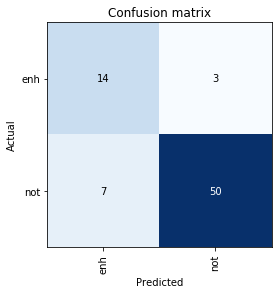

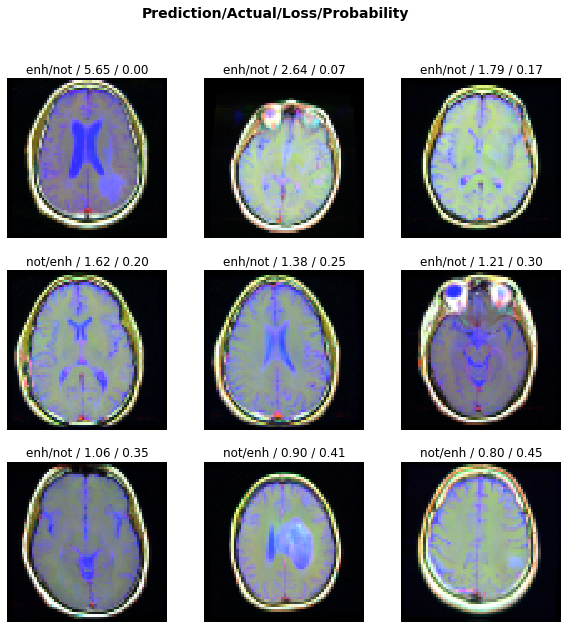

In [0]:
# Cell #7
# now we are ready to load data and train classifier
# while we did this in separate cells before, we will do it all in one
# this should look familiar.
!pip3 install fastai
from fastai.vision import *

classes_dir = "./classified"

np.random.seed(42)
data = ImageDataBunch.from_folder(classes_dir, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=64, num_workers=4).normalize(imagenet_stats)
data.classes
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

learn = cnn_learner(data, models.resnet34, metrics=error_rate)

learn.fit_one_cycle(50)

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
# not great performance. 
# look at some errors--why is it failing? 
interp.plot_top_losses(9, figsize=(10,10))
doc(interp.plot_top_losses)
